In [1]:
import tensorflow as tf

/home/mkk/anaconda3/envs/receptivefield/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append("../src/")

In [5]:
import tf_optimizer as tf_opt

In [82]:
import sklearn.datasets as sk_datasets

In [262]:
ndims = 10
Q = sk_datasets.make_spd_matrix(ndims).astype(np.float32)
b = np.random.randn(ndims, 1).astype(np.float32)
w0 = np.random.randn(ndims, 1).astype(np.float32)
w_exact = np.linalg.inv(Q) @ b
w_exact_norm = np.linalg.norm(w_exact) + 1e-6

In [329]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

/home/mkk/anaconda3/envs/receptivefield/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [330]:
weights = tf.get_variable(
    name='w', 
    dtype=tf.float32, 
    initializer=w0)

In [331]:
# x^T Q x + b^T x
loss = 0.5 * tf.matmul(tf.transpose(weights), tf.matmul(Q, weights)) \
     - tf.matmul(tf.transpose(b), weights)

rel_dist = tf.sqrt(tf.reduce_sum(tf.square(weights - w_exact)))/w_exact_norm
    
lr_ph = tf.placeholder(tf.float32, shape=())

In [332]:
with tf.variable_scope('opt'):
    optimizer = tf_opt.NormalizedSGD(lr=lr_ph, lr_update=0.05, lr_max=None, lr_min=None)
    optimizer = tf.train.AdamOptimizer(lr_ph)
    optimizer = tf.train.MomentumOptimizer(lr_ph, 0.2)
    
update_op = optimizer.minimize(loss)
# optimizer._lr_variables

In [333]:
eps = 1e-6
max_iter = 1000
lr_steps = []
from tqdm import tqdm

In [334]:
for lr_np in tqdm(np.linspace(0.01, 0.5, 100)):
    sess.run(tf.global_variables_initializer(), feed_dict={lr_ph: lr_np})    
    for i in range(max_iter):
        dist, _ = sess.run(
            [rel_dist, update_op], 
            feed_dict={lr_ph: lr_np})
        if np.isinf(dist):
            break
        if dist <= eps:
            lr_steps.append([lr_np, i, dist])   
            break
    if dist > eps or np.isinf(dist):
        lr_steps.append([lr_np, max_iter, dist])

100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


In [335]:
lr_steps = np.array(lr_steps)


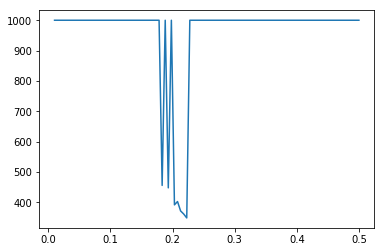

In [336]:
plt.plot(lr_steps[:, 0], lr_steps[:, 1])

In [214]:
lr_steps

array([], dtype=float64)

In [148]:
sess.run(optimizer._lr_variables[0])

0.0002896634

In [149]:
optimizer._lr_variables

[<tf.Variable 'w/lr:0' shape=() dtype=float32_ref>]

In [150]:
w_exact

array([[-0.82221806],
       [-0.8831981 ],
       [-1.5417752 ],
       [-2.6781852 ],
       [ 1.3663499 ]], dtype=float32)